# Testing DoWhy's Limits

In [249]:
# Imports

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import sys
sys.path.append('../')
from parser_uai import UAIParser

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Instrumental Variable Basic Example

<center><img src="./figures/image.png"/></center>

### Continuous Variables

In [196]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [197]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,-5.463104,1.422533,3.030729,7.300007
1,1.600392,0.644585,6.230665,34.837678
2,-2.579008,1.535212,5.943313,26.000605
3,2.225508,1.422588,9.060396,47.597609
4,2.855053,1.451390,10.221369,57.678172


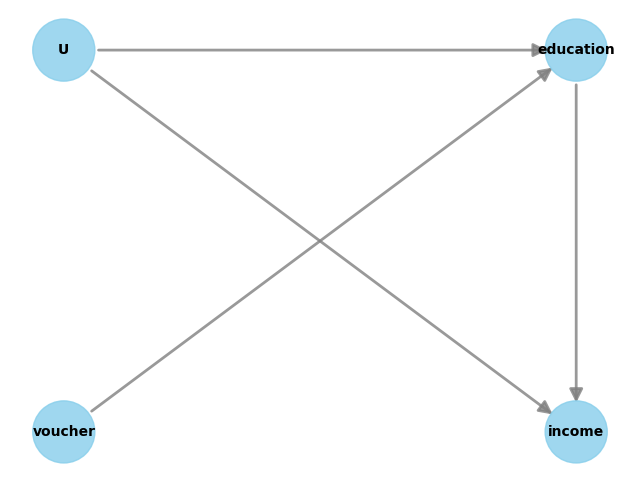

In [198]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [199]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [200]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.9058599728351524
New effect:-0.00020895552331076317
p value:0.94



In [201]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.6317358765103718
New effect:-0.02509562008298294
p value:0.96



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [202]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,1.422533,3.030729,7.300007
1,0.644585,6.230665,34.837678
2,1.535212,5.943313,26.000605
3,1.422588,9.060396,47.597609
4,1.451390,10.221369,57.678172


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


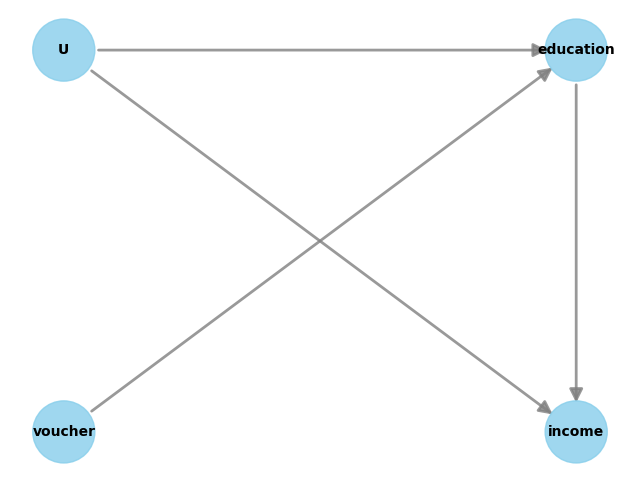

In [203]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [204]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [205]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.6317358765103718
New effect:-0.006664074208887606
p value:0.94



### Discrete Variables

- Function as continuous variables

In [206]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher


# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [207]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,-2,2,5,27
1,0,2,9,46
2,-2,2,8,40
3,1,1,10,58
4,0,2,8,44


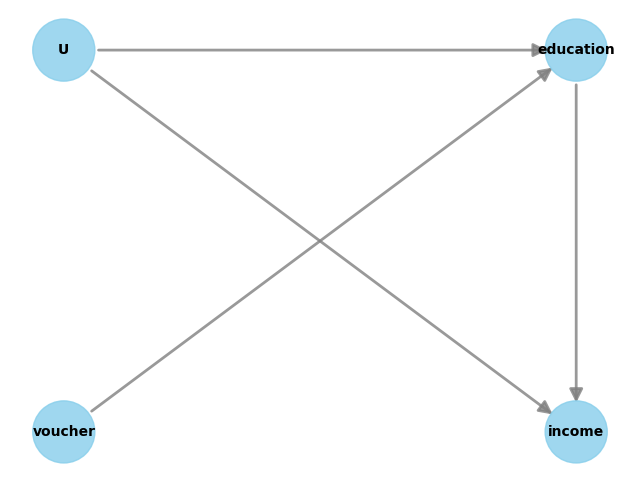

In [208]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [209]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [210]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.035816387628234
New effect:-0.003298264537280602
p value:0.94



In [211]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.024799525043297
New effect:-0.02971105888532919
p value:0.88



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [212]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,2,5,27
1,2,9,46
2,2,8,40
3,1,10,58
4,2,8,44


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


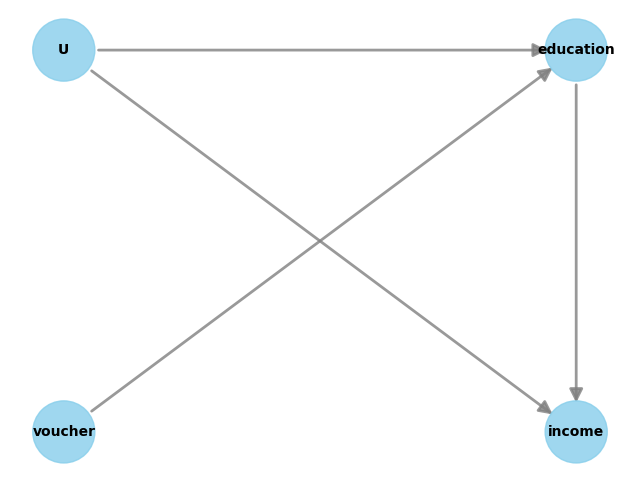

In [213]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [214]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [215]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.024799525043297
New effect:0.03805782105404274
p value:0.96



### Discrete Variables (binary treatment)

In [230]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = np.where(education < education.mean(), 0, 1)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- IV method only works depending on the data

In [231]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,1,2,0,13
1,-5,1,0,-2
2,-1,1,0,7
3,-2,4,0,2
4,2,0,0,13


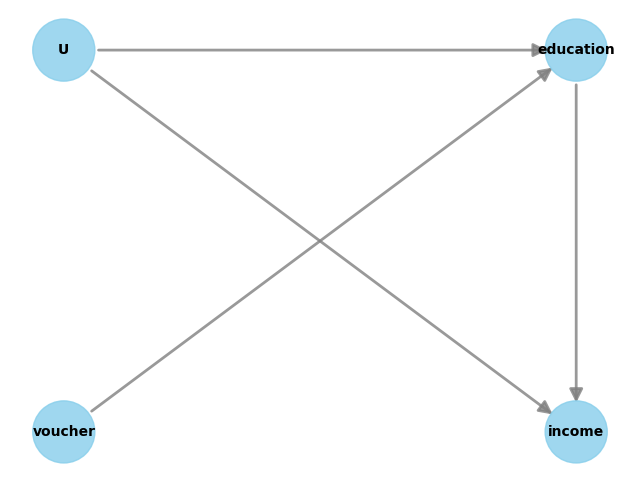

In [232]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [233]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [234]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.9870347440636635
New effect:0.012600717014091423
p value:0.9199999999999999



In [235]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.003703273552503
New effect:-0.025438598742477482
p value:0.88



In [236]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- IV method works depending on the data
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [237]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,2,0,13
1,1,0,-2
2,1,0,7
3,4,0,2
4,0,0,13


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


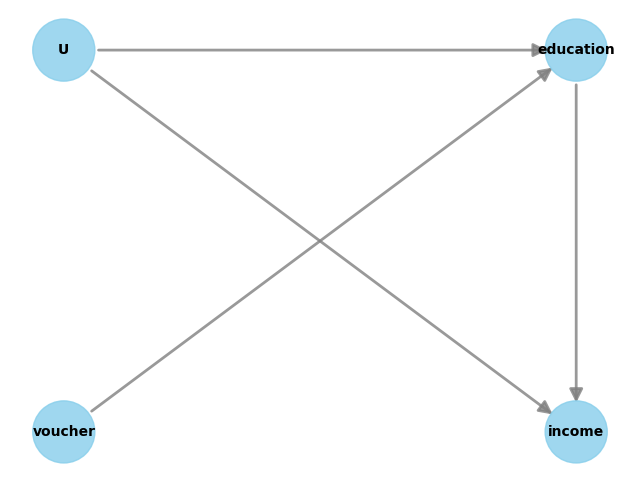

In [238]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [239]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [240]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### All binary variables

In [151]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
ability, voucher, education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [ability, voucher, education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [152]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,0,0,0,0
1,1,1,1,1
2,1,0,1,1
3,0,0,0,0
4,1,0,1,1


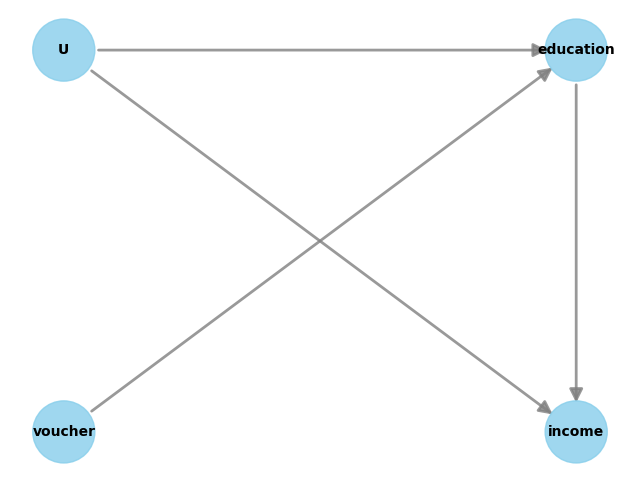

In [153]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [155]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [156]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6905817546688148
New effect:-0.0001648619938847984
p value:0.9199999999999999



In [157]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6902336604571891
New effect:-0.000555596080003369
p value:0.88



In [158]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [161]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,0,0,0
1,1,1,1
2,0,1,1
3,0,0,0
4,0,1,1


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


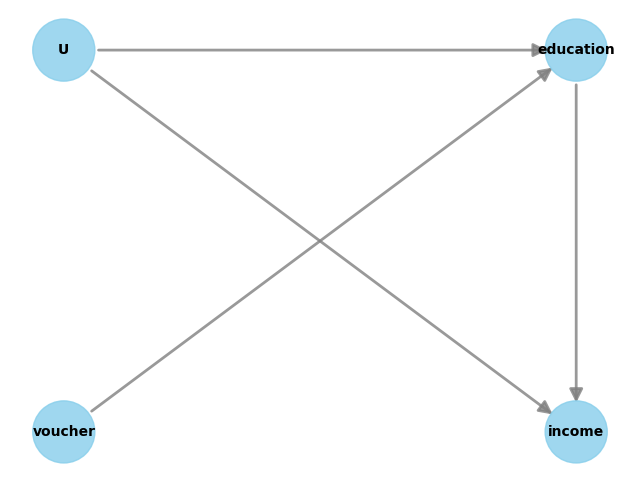

In [162]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [163]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [164]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Binary treatment and outcome, discrete IV and confounder

In [166]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [168]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,-1,3,1,1
1,0,3,1,1
2,-2,2,0,0
3,0,2,1,1
4,-1,2,1,1


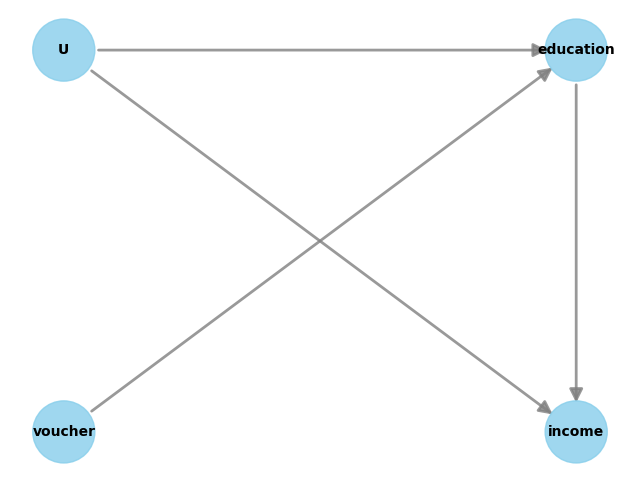

In [169]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [170]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [176]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.7193421011020578
New effect:-0.0008199390318250061
p value:0.96



In [175]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6793619919207263
New effect:0.004033224993707715
p value:0.9199999999999999



In [177]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [178]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,3,1,1
1,3,1,1
2,2,0,0
3,2,1,1
4,2,1,1


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


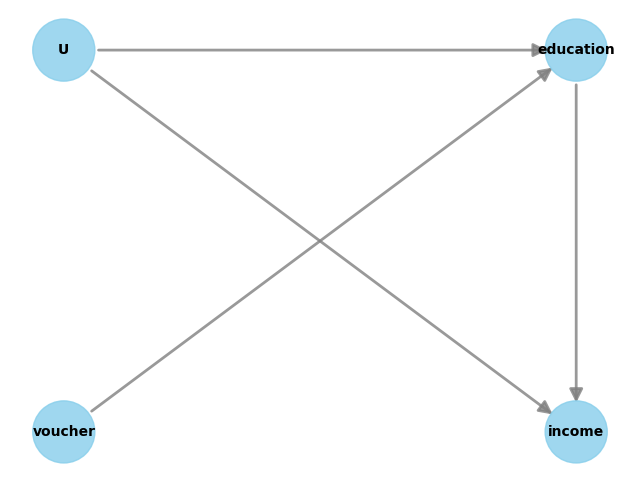

In [179]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [180]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [181]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Discrete Variables (binary outcome)

In [182]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = dowhy.datasets.convert_continuous_to_discrete(education)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
income = np.where(income < income.mean(), 0, 1)

#### Without latent variables

- In this scenario the IV method worked for some reason

In [183]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,1,3,10,1
1,-1,1,6,0
2,2,2,11,1
3,2,3,13,1
4,-2,1,6,0


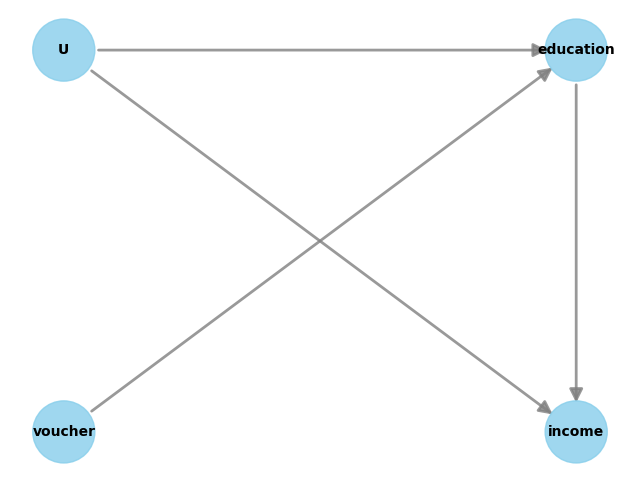

In [184]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [185]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [186]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.10170544008982452
New effect:-0.0002948029390626122
p value:0.94



In [188]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [189]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,3,10,1
1,1,6,0
2,2,11,1
3,3,13,1
4,1,6,0


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


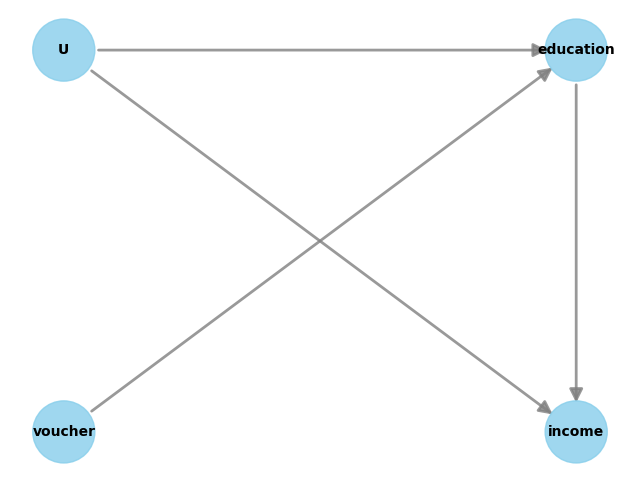

In [190]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [191]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [192]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

## Basic Confounder Example

<center><img src="./figures/image-1.png"></center>

### Binary Treatment and Outcome, Discrete Confounder

In [245]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn3.uai", ["X1", "X2", "U1"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data

,X1,X2,U1
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
95,1,1,3
96,1,1,3
97,1,1,3
98,1,1,3


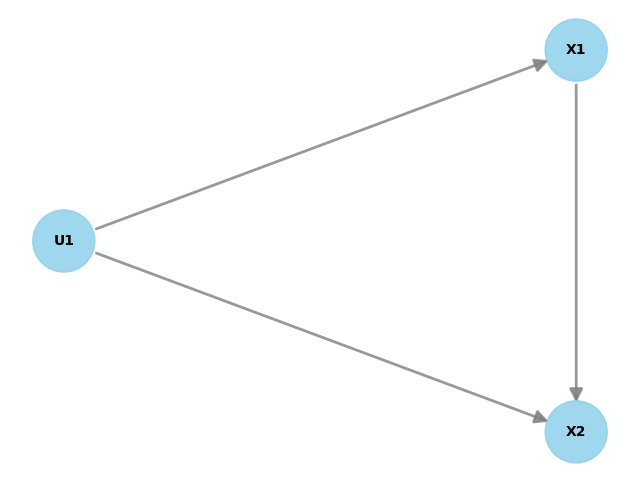

In [250]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()